# COMPUTER VISION AND PATTERN RECOGNITION PROJECT
## Alessandro Cesa

In [1]:
import torch.optim as optim
from torch.utils.data import DataLoader,ConcatDataset
from torchvision.datasets import ImageFolder

In [2]:
%%capture 
#Run if you don't already have the dataset
"""
!git clone https://github.com/AlessandroCesaTs/Computer_Vision_Project_Cesa.git
"""

In [3]:
#Adjust according to your path
import sys
sys.path.append('/orfeo/cephfs/home/dssc/acesa000/Computer_Vision_Project_Cesa/functions')

from image_handling_functions import *
from train_test_functions import *
from neural_networks import *

In [4]:
#Adjust according to your path
train_path = "/orfeo/cephfs/home/dssc/acesa000/Computer_Vision_Project_Cesa/CVPR2023_project_2_and_3_data/train"
test_path = "/orfeo/cephfs/home/dssc/acesa000/Computer_Vision_Project_Cesa/CVPR2023_project_2_and_3_data/test"

In [5]:
device = get_default_device()

In [6]:
np.random.seed(123)
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if device.type == 'cuda':
    torch.cuda.empty_cache()

In [7]:
train=ImageFolder(root=train_path,transform=resize_transformation)
test=ImageFolder(root=test_path,transform=resize_transformation)

In [8]:
%%capture
"""
# check the dataset size
print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")
print(train.classes)
"""

In [9]:
%%capture
"""
# get image no. 1 and its label
index=1
img,label=train[index]

print(f"label: {label}")

print("class: " + train.classes[label])
# display
figure = plt.figure()
plt.imshow(img.numpy().transpose((1, 2, 0)),cmap='gray') #<< swap axes because img is (3,H,W) but imshow() expects (H,W,3)
"""

In [10]:
#split training set into training and validation
train_size=int(0.85*len(train))
validation_size=len(train)-train_size
training_set,validation_set=torch.utils.data.random_split(train,[train_size,validation_size])

In [11]:
# Create data loaders.
# Data loaders are basically objects that make easy to iterate through the data by batches of some batch_size
batch_size = 32
train_loader = DataLoader(training_set, batch_size=batch_size,shuffle=True,pin_memory=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size,shuffle=False,pin_memory=True)
test_loader = DataLoader(test, batch_size=batch_size,shuffle=False,pin_memory=True)

In [12]:
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [13]:
%%capture
"""
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
"""

In [14]:
%%capture
"""
classes=train.classes

# get a batch from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)   #images is a (batch_size,3,32,32) tensor

print(images.size())

img=torchvision.utils.make_grid(images)
figure = plt.figure()
plt.imshow(img.cpu().numpy().transpose((1, 2, 0)).astype(np.uint8),cmap='gray') #<< swap axes because img is (3,H,W) but imshow() expects (H,W,3)

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
"""

In [15]:
# Instantiate the model
model = simpleCNN()
model.to(device)
model.apply(init_weights)
loss_function=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.0004,momentum=0.9)
# Print the model summary
#print(model)

EPOCH1:
LOSS train: 2.7080834686756132 validation: 2.709959030151367 | validation_accuracy: 6.222222222222222% 
EPOCH2:
LOSS train: 2.707673192024231 validation: 2.7109193801879883 | validation_accuracy: 5.777777777777778% 
EPOCH3:
LOSS train: 2.7074856042861937 validation: 2.711177110671997 | validation_accuracy: 5.777777777777778% 
EPOCH4:
LOSS train: 2.7069859385490416 validation: 2.713294744491577 | validation_accuracy: 5.777777777777778% 
EPOCH5:
LOSS train: 2.705793434381485 validation: 2.7124738693237305 | validation_accuracy: 5.777777777777778% 
EPOCH6:
LOSS train: 2.7036907613277434 validation: 2.712118625640869 | validation_accuracy: 6.222222222222222% 
EPOCH7:
LOSS train: 2.7025950729846953 validation: 2.704118251800537 | validation_accuracy: 7.111111111111111% 
EPOCH8:
LOSS train: 2.694780695438385 validation: 2.697244882583618 | validation_accuracy: 9.333333333333334% 
EPOCH9:
LOSS train: 2.6768413901329042 validation: 2.6328015327453613 | validation_accuracy: 8.8888888888

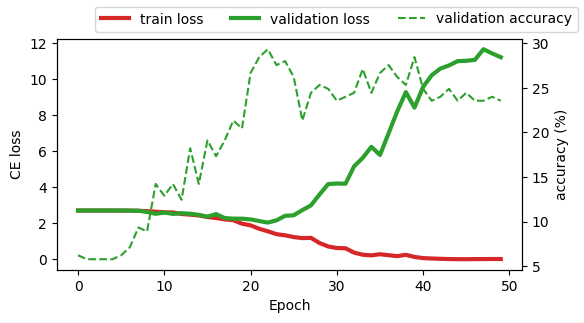

In [16]:
model_path=train_model(model,train_loader,validation_loader,loss_function,optimizer,50,device)

Accuracy of the network on the test images: 29.31323283082077%


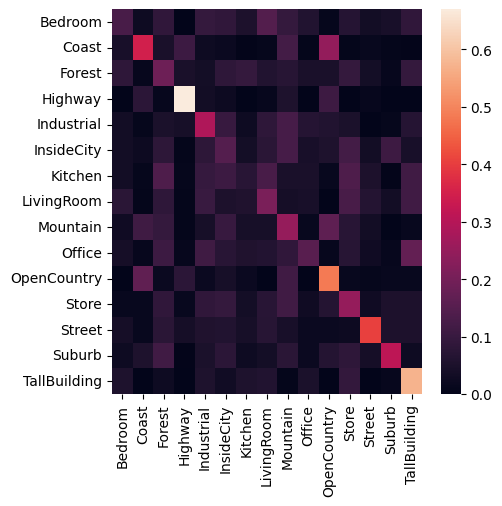

In [17]:
test_model(simpleCNN(),model_path,test_loader,test,device)

In [18]:
!rm model*

In [20]:
np.random.seed(123)
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if device.type == 'cuda':
    torch.cuda.empty_cache()

In [21]:
augmented_training_set=TransformedDataSet(training_set)
concatenated_dataset = torch.utils.data.ConcatDataset([training_set, augmented_training_set])
augmented_train_loader = DataLoader(concatenated_dataset, batch_size=batch_size,shuffle=True,pin_memory=True)
augmented_train_loader = DeviceDataLoader(augmented_train_loader, device)

In [21]:
model = simpleCNN()
model.to(device)
model.apply(init_weights)
loss_function=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.00035,momentum=0.8)

EPOCH1:
LOSS train: 2.707965213060379 validation: 2.71002197265625 | validation_accuracy: 5.777777777777778% 
EPOCH2:
LOSS train: 2.707623714208603 validation: 2.7108240127563477 | validation_accuracy: 5.777777777777778% 
EPOCH3:
LOSS train: 2.707270845770836 validation: 2.711373805999756 | validation_accuracy: 5.777777777777778% 
EPOCH4:
LOSS train: 2.706422221660614 validation: 2.71303129196167 | validation_accuracy: 5.777777777777778% 
EPOCH5:
LOSS train: 2.7050274670124055 validation: 2.7136685848236084 | validation_accuracy: 5.777777777777778% 
EPOCH6:
LOSS train: 2.7030171543359756 validation: 2.711404323577881 | validation_accuracy: 6.222222222222222% 
EPOCH7:
LOSS train: 2.6984178572893143 validation: 2.701059103012085 | validation_accuracy: 8.0% 
EPOCH8:
LOSS train: 2.6856020480394363 validation: 2.635402202606201 | validation_accuracy: 12.88888888888889% 
EPOCH9:
LOSS train: 2.642678439617157 validation: 2.5083601474761963 | validation_accuracy: 12.88888888888889% 
EPOCH10:
L

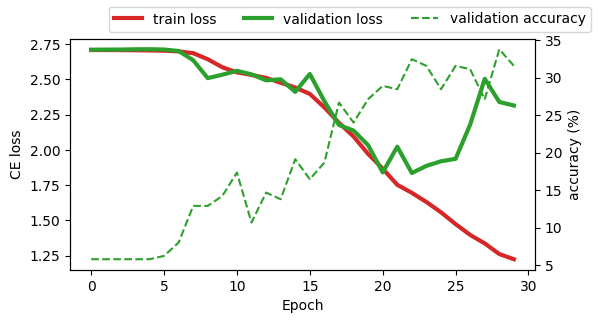

In [22]:
model_path=train_model(model,augmented_train_loader,validation_loader,loss_function,optimizer,30,device)

Accuracy of the network on the test images: 34.90787269681742%


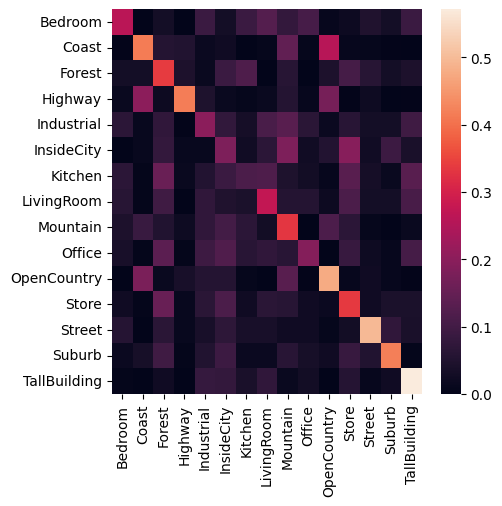

In [23]:
test_model(simpleCNN(),model_path,test_loader,test,device)

In [24]:
!rm model*

In [22]:
np.random.seed(123)
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if device.type == 'cuda':
    torch.cuda.empty_cache()

In [23]:
model = batchNormCNN()
model.to(device)
model.apply(init_weights)
loss_function=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.00035,momentum=0.8)

EPOCH1:
LOSS train: 2.5181635111570357 validation: 2.8365230560302734 | validation_accuracy: 12.0% 
EPOCH2:
LOSS train: 2.106581209599972 validation: 3.955852508544922 | validation_accuracy: 9.777777777777779% 
EPOCH3:
LOSS train: 1.87413290143013 validation: 2.529480218887329 | validation_accuracy: 20.444444444444443% 
EPOCH4:
LOSS train: 1.7039721578359603 validation: 1.9558181762695312 | validation_accuracy: 36.44444444444444% 
EPOCH5:
LOSS train: 1.5575527772307396 validation: 1.848027229309082 | validation_accuracy: 39.55555555555556% 
EPOCH6:
LOSS train: 1.457713457942009 validation: 2.4044113159179688 | validation_accuracy: 28.88888888888889% 
EPOCH7:
LOSS train: 1.3432350292801858 validation: 1.801225185394287 | validation_accuracy: 42.22222222222222% 
EPOCH8:
LOSS train: 1.282635537534952 validation: 1.9851949214935303 | validation_accuracy: 35.55555555555556% 
EPOCH9:
LOSS train: 1.197338581830263 validation: 1.929447054862976 | validation_accuracy: 36.0% 
EPOCH10:
LOSS train

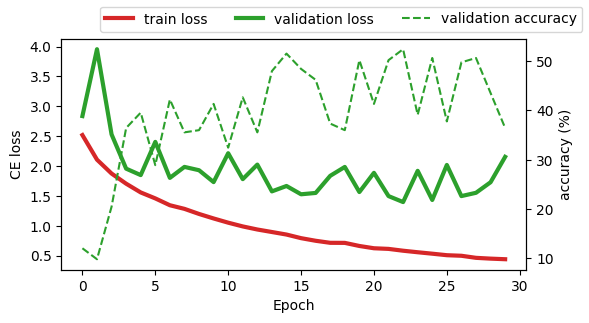

In [24]:
model_path=train_model(model,augmented_train_loader,validation_loader,loss_function,optimizer,30,device)

Accuracy of the network on the test images: 21.306532663316585%


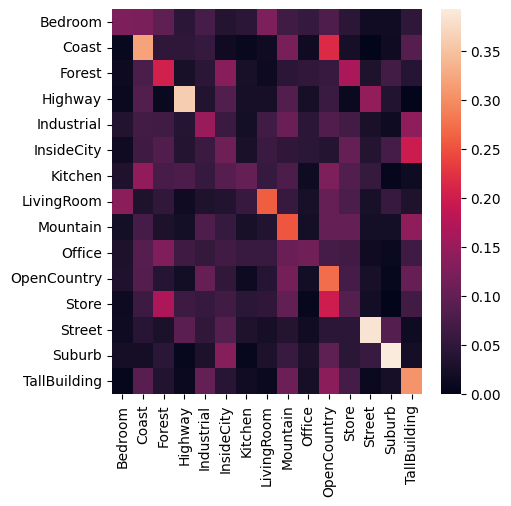

In [26]:
test_model(batchNormCNN(),model_path,test_loader,test,device)

In [27]:
!rm model*